fatal: destination path 'pokemon_pca' already exists and is not an empty directory.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


(809, 120, 120, 3) (809, 28, 28, 1)


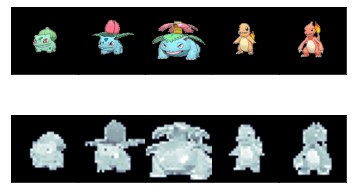

In [5]:
!git clone https://github.com/peterjsadowski/pokemon_pca.git # Retrieves data set.

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from PIL import Image

# Only keep pokemon for which we have images and meta data.
filenames = [f[2] for f in os.walk('./pokemon_pca/data/images/')][0]
pokemon_names = [f.split('/')[-1].split('.')[0] for f in filenames]
df = pd.read_csv('./pokemon_pca/data/pokemon.csv', index_col=0)

# One hot encode the pokemon's primary type
pokemon_types= df['Type1'].unique()
labels_names = df['Type1']
labels_one_hot = pd.get_dummies(labels_names, columns=pokemon_types)
labels_idx = np.argmax(labels_one_hot.to_numpy(), axis=1) # Get label as integer.

# Go through add grab images and save them to list.
imgs = []
gray_imgs = []
for name in df.index:
  filename = glob.glob(f'./pokemon_pca/data/images/{name}.*')[0]
  
  # Open the image with PIL and save it as grayscale color and grayscale but in RGB format
  img = Image.open(filename).convert('RGB') # Some are RGBA so we convert them
  imgs.append(np.array(img))
  # Save a gray scale version,.
  gray_img = np.array(img.convert('L') )
  if gray_img[0,0] == 255:
    gray_img = 255 - gray_img # invert colors. Example 9 had this problem.
  # Crop (weird edge effects on bottom)
  gray_img = gray_img[15:99,15:99]
  # Downsample (makes pca faster).
  input_size = 84
  output_size = 28
  bin_size = input_size // output_size
  gray_img = gray_img.reshape((output_size, bin_size, output_size, bin_size)).max(3).max(1)
  gray_imgs.append(gray_img)

# Convert lists to numpy arrays.
imgs = np.array(imgs)
gray_imgs = np.array(gray_imgs)
gray_imgs = np.expand_dims(gray_imgs, axis=-1)
print(imgs.shape, gray_imgs.shape)

# Show some original images and grayscale downsampled versions.
fig,ax = plt.subplots(2,5, gridspec_kw = {'wspace':0, 'hspace':0}) 
for i in range(0,5,1):
  ax[0,i].imshow(imgs[i,:,:])
  ax[1,i].imshow(gray_imgs[i,:,:,0], cmap=plt.get_cmap('bone'))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

# Save data.
np.savetxt(fname='pokemon_mnist_images.csv', X=gray_imgs.astype('uint8').reshape(-1, 784), fmt='%4d', delimiter=',')
with open('pokemon_mnist_info.csv', 'w') as f:
  for i,name in enumerate(df.index):
    f.write(f'{name} {labels_names[i]}\n')

from google.colab import files
files.download('pokemon_mnist_images.csv') 
files.download('pokemon_mnist_info.csv') 
